# Training ResNet50

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization


X_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_train_256x192.npy")
y_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/train_labels.npy")

X_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_val_256x192.npy")
y_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/val_labels.npy")

y_train = to_categorical(y_train).astype('float32')
y_val = to_categorical(y_val).astype('float32')

# ResNet50
pretrained_model = ResNet50(input_shape=(192, 256, 3), include_top=False, weights="imagenet")




for layer in pretrained_model.layers:
    if isinstance(layer, BatchNormalization):  
        layer.trainable = True  
        layer.moving_mean.assign(tf.zeros_like(layer.moving_mean))
        layer.moving_variance.assign(tf.zeros_like(layer.moving_variance))
    else:
        layer.trainable = False  

last_layer = pretrained_model.get_layer('conv5_block3_out') 
print('Last layer output shape:', last_layer.output.shape)
last_output = last_layer.output

x = layers.GlobalMaxPooling2D()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)

model = Model(pretrained_model.input, x)

# Compile
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])


Last layer output shape: (None, 6, 8, 2048)


In [3]:
train_datagenerator = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagenerator.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

batch_size = 64
epochs = 3
history = model.fit(train_datagenerator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_val, y_val),
                    verbose=1,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    validation_steps=(X_val.shape[0] // batch_size))

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 1299s 10s/step - accuracy: 0.5576 - loss: 4.6260 - precision: 0.5680 - recall: 0.5508 - val_accuracy: 0.5714 - val_loss: 26.8741 - val_precision: 0.5708 - val_recall: 0.5670
Epoch 2/3
  1/126 ━━━━━━━━━━━━━━━━━━━━ 21:17 10s/step - accuracy: 0.6562 - loss: 1.3671 - precision: 0.7143 - recall: 0.6250

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - accuracy: 0.6562 - loss: 1.3671 - precision: 0.7143 - recall: 0.6250 - val_accuracy: 0.5580 - val_loss: 26.2988 - val_precision: 0.5608 - val_recall: 0.5558
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 1179s 9s/step - accuracy: 0.6572 - loss: 1.0902 - precision: 0.7422 - recall: 0.5900 - val_accuracy: 0.6607 - val_loss: 1.0653 - val_precision: 0.7375 - val_recall: 0.6272


In [4]:
for layer in pretrained_model.layers[81:]:  # Adjust this index based on your model structure
    layer.trainable = True


optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                              min_lr=0.000001, cooldown=2)

batch_size = 64
epochs = 10
history = model.fit(train_datagenerator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_val, y_val),
                    verbose=1)

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1373s 11s/step - accuracy: 0.6900 - loss: 0.9068 - precision: 0.8046 - recall: 0.6179 - val_accuracy: 0.7251 - val_loss: 0.9259 - val_precision: 0.7741 - val_recall: 0.6763
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1398s 11s/step - accuracy: 0.7587 - loss: 0.6798 - precision: 0.8421 - recall: 0.6822 - val_accuracy: 0.7550 - val_loss: 0.6920 - val_precision: 0.8145 - val_recall: 0.7106
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1333s 10s/step - accuracy: 0.7781 - loss: 0.5890 - precision: 0.8535 - recall: 0.7133 - val_accuracy: 0.7794 - val_loss: 0.6872 - val_precision: 0.8158 - val_recall: 0.7461
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1313s 10s/step - accuracy: 0.7923 - loss: 0.5591 - precision: 0.8547 - recall: 0.7325 - val_accuracy: 0.7938 - val_loss: 0.5827 - val_precision: 0.8339 - val_recall: 0.7572
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1287s 10s/step - accuracy: 0.8155 - loss: 0.4751 - precision: 0.8659 - recall: 0.7672 - val_accuracy: 0.8126

In [6]:
results = model.evaluate(X_val, y_val, verbose=1)
loss_val = results[0]
acc_val = results[1]
precision_val = results[2]
recall_val = results[3]

print("Validation: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (acc_val, loss_val, precision_val, recall_val))

29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8230 - loss: 0.5663 - precision: 0.8502 - recall: 0.8136
Validation: accuracy = 0.813747  ;  loss = 0.603285  ;  precision = 0.838560  ;  recall = 0.800443


# Testing ResNet50

In [7]:
X_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_test_256x192.npy")

y_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/test_labels.npy")
y_test = to_categorical(y_test)


results = model.evaluate(X_test, y_test, verbose=1)

loss_test = results[0]
accuracy_test = results[1]
precision_test = results[2]
recall_test = results[3]

print("Test: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (accuracy_test, loss_test, precision_test, recall_test))



model.save("ResNet50.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8042 - loss: 0.6795 - precision: 0.8199 - recall: 0.7848


Test: accuracy = 0.827345  ;  loss = 0.590081  ;  precision = 0.841779  ;  recall = 0.812375


Text(0.5, 1.0, 'Training and validation loss')

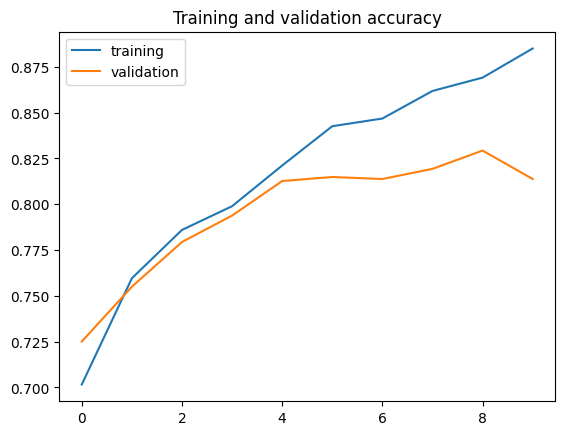

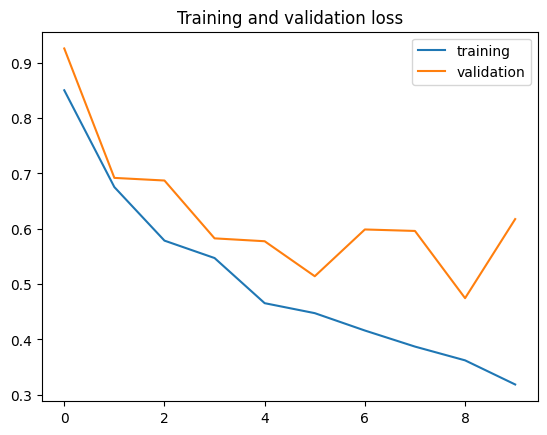

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label="training")
plt.plot(epochs, val_acc, label="validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label="training")
plt.plot(epochs, val_loss, label="validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')
